# Simultaneous discrimination ttH vs ttW and ttbar 

load datasets

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
hd_ttH=pandas.read_hdf('../../Files/skimmed/ttH.h5', 'df')
hd_ttW=pandas.read_hdf('../../Files/skimmed/ttW.h5', 'df')
hd_ttbar=pandas.read_hdf('../../Files/skimmed/ttbar.h5', 'df')

In [3]:
with open("../VarList_30.json") as vardict:
    variablelist = json.load(vardict)[:]

In [4]:
len(variablelist)

30

In [9]:
variablelist_all=variablelist

In [10]:
ttH_vars=hd_ttH[variablelist_all]
ttW_vars=hd_ttW[variablelist_all]
ttbar_vars=hd_ttbar[variablelist_all]

## Three classes

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Dense, Activation, Input, add
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback

Using TensorFlow backend.


In [11]:
# 
X = np.concatenate((ttH_vars,ttW_vars,ttbar_vars)) # training data   
sc = StandardScaler()
X = sc.fit_transform(X)
y = np.concatenate((np.zeros(ttH_vars.shape[0]),np.ones(ttW_vars.shape[0]),2*np.ones(ttbar_vars.shape[0]))) # class lables                                                                                           



In [12]:
from keras.utils import np_utils

In [13]:
len(y)
y[157602]

2.0

In [14]:
Y = np_utils.to_categorical(y, 3)

In [15]:
print(Y[10],Y[69902],Y[157602])

[1. 0. 0.] [0. 1. 0.] [0. 0. 1.]


In [16]:
from sklearn.model_selection import train_test_split
seed=8
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [17]:
yy = np.ones((ttH_vars.shape[0], 3))
yy

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       ...,
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [18]:
yy.shape[0]

69902

In [19]:
inputs = Input(shape=(X_train.shape[1],))
inputs

<tf.Tensor 'input_1:0' shape=(?, 30) dtype=float32>

In [20]:
# number of nodes in the different hidden layers
l_units = [ 60, 48, 36, 24, 12, 6]

In [21]:
x = inputs

In [22]:
for unit in l_units:
    x = Dense(units=unit, activation="linear", kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

In [23]:
# output layer, using softmax which will return a probability for each jet to be either light, c- or b-jet
predictions = Dense(units=3, activation='softmax',
                    kernel_initializer='glorot_uniform')(x)


In [24]:
model = Model(inputs=inputs, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                1860      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60)                240       
_________________________________________________________________
activation_1 (Activation)    (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                2928      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48)                192       
_________________________________________________________________
activation_2 (Activation)    (None, 48)                0         
__________

In [25]:
model_optimizer = Adam(lr=0.01)
model.compile(  # loss='mse',
    loss='categorical_crossentropy',
    optimizer=model_optimizer,
    metrics=['accuracy']
)

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.00001)

In [27]:
model.fit(X_train, y_train,
          validation_data=[X_test[:], y_test[:]],
          epochs=10, # typically ~130 are necessary to converge
          batch_size=3000,
          #callback=reduce_lr,
          )

Train on 105677 samples, validate on 52051 samples
Epoch 1/10
105677/105677 [==============================] - 2s 24us/step - loss: 0.7588 - acc: 0.6432 - val_loss: 0.6985 - val_acc: 0.6786
Epoch 2/10
105677/105677 [==============================] - 1s 7us/step - loss: 0.6168 - acc: 0.6902 - val_loss: 0.6262 - val_acc: 0.6946
Epoch 3/10
105677/105677 [==============================] - 1s 7us/step - loss: 0.6031 - acc: 0.6981 - val_loss: 0.6093 - val_acc: 0.6993
Epoch 4/10
105677/105677 [==============================] - 1s 7us/step - loss: 0.5963 - acc: 0.7020 - val_loss: 0.6052 - val_acc: 0.7012
Epoch 5/10
105677/105677 [==============================] - 1s 7us/step - loss: 0.5918 - acc: 0.7064 - val_loss: 0.6087 - val_acc: 0.7049
Epoch 6/10
105677/105677 [==============================] - 1s 7us/step - loss: 0.5874 - acc: 0.7082 - val_loss: 0.6017 - val_acc: 0.7061
Epoch 7/10
105677/105677 [==============================] - 1s 7us/step - loss: 0.5849 - acc: 0.7117 - val_loss: 0.6001 

In [28]:
y_pred = model.predict(X_test, batch_size=5000)

In [29]:
#   b_index, c_index, u_index = 2, 1, 0
#(np.zeros(len(ujets_scaled)),
#                          np.ones(len(cjets_scaled)),
#                          2 * np.ones(len(bjets_scaled))))

def GetClass(y_pred, y_true):
    """Calculates ..."""
    ttH_index, ttW_index, ttbar_index = 0, 1, 2
    y_true = np.argmax(y_true, axis=1)
    ttH_proc = y_pred[y_true == ttH_index]
    ttW_proc = y_pred[y_true == ttW_index]
    ttbar_proc = y_pred[y_true == ttbar_index]
#    bscores = np.log(b_jets[:, b_index] / (cfrac * b_jets[:, c_index] +
#                                           (1 - cfrac) * b_jets[:, u_index]))
#    cutvalue = np.percentile(bscores, 100.0 * (1.0 - target_beff))

#   c_eff = len(c_jets[np.log(c_jets[:, b_index] / (cfrac * c_jets[:, c_index]
#                                                    + (1 - cfrac) *
#                                                    c_jets[:, u_index])) >
#                       cutvalue]) / float(len(c_jets))
#    u_eff = len(u_jets[np.log(u_jets[:, b_index] / (cfrac *
#                                                   u_jets[:, c_index] +
#                                                    (1 - cfrac) *
#                                                    u_jets[:, u_index])) >
#                       cutvalue]) / float(len(u_jets))

#    if c_eff == 0 or u_eff == 0:
#        return -1, -1
    return ttH_proc, ttW_proc, ttbar_proc

In [42]:
GetClass(y_pred,y_test)

(array([[0.8273561 , 0.15844838, 0.01419546],
        [0.94000393, 0.0519188 , 0.0080773 ],
        [0.9300451 , 0.06838583, 0.00156898],
        ...,
        [0.9443363 , 0.04894974, 0.00671404],
        [0.05745863, 0.94117564, 0.00136581],
        [0.8424377 , 0.15465364, 0.00290869]], dtype=float32),
 array([[0.6131526 , 0.3852848 , 0.00156255],
        [0.08686986, 0.90854394, 0.00458612],
        [0.27862123, 0.72023994, 0.00113888],
        ...,
        [0.41480753, 0.5821833 , 0.00300916],
        [0.7422865 , 0.2552351 , 0.00247833],
        [0.02715508, 0.9710579 , 0.00178695]], dtype=float32),
 array([[0.3088373 , 0.6846913 , 0.00647136],
        [0.19749239, 0.7791241 , 0.02338357],
        [0.782633  , 0.20852625, 0.00884073],
        ...,
        [0.535657  , 0.42313415, 0.04120891],
        [0.16345903, 0.82866746, 0.00787353],
        [0.8057838 , 0.17463717, 0.01957906]], dtype=float32))

In [43]:
ttH_proc1, ttW_proc1, ttbar_proc1 = GetClass(y_pred,y_test)

In [94]:
y_pred

array([[0.6131526 , 0.3852848 , 0.00156255],
       [0.08686986, 0.90854394, 0.00458612],
       [0.8273561 , 0.15844838, 0.01419546],
       ...,
       [0.05745863, 0.94117564, 0.00136581],
       [0.8424377 , 0.15465364, 0.00290869],
       [0.02715508, 0.9710579 , 0.00178695]], dtype=float32)

In [95]:
y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [98]:
y_true = np.argmax(y_test, axis=1)
y_true

array([1, 1, 0, ..., 0, 0, 1])

In [99]:
y_pred[y_true == 2]

array([[0.3088373 , 0.6846913 , 0.00647136],
       [0.19749239, 0.7791241 , 0.02338357],
       [0.782633  , 0.20852625, 0.00884073],
       ...,
       [0.535657  , 0.42313415, 0.04120891],
       [0.16345903, 0.82866746, 0.00787353],
       [0.8057838 , 0.17463717, 0.01957906]], dtype=float32)

In [59]:
ttH_proc1

array([[0.8273561 , 0.15844838, 0.01419546],
       [0.94000393, 0.0519188 , 0.0080773 ],
       [0.9300451 , 0.06838583, 0.00156898],
       ...,
       [0.9443363 , 0.04894974, 0.00671404],
       [0.05745863, 0.94117564, 0.00136581],
       [0.8424377 , 0.15465364, 0.00290869]], dtype=float32)

In [72]:
ttW_proc1

array([[0.6131526 , 0.3852848 , 0.00156255],
       [0.08686986, 0.90854394, 0.00458612],
       [0.27862123, 0.72023994, 0.00113888],
       ...,
       [0.41480753, 0.5821833 , 0.00300916],
       [0.7422865 , 0.2552351 , 0.00247833],
       [0.02715508, 0.9710579 , 0.00178695]], dtype=float32)

In [80]:
ttbar_proc1

array([[0.3088373 , 0.6846913 , 0.00647136],
       [0.19749239, 0.7791241 , 0.02338357],
       [0.782633  , 0.20852625, 0.00884073],
       ...,
       [0.535657  , 0.42313415, 0.04120891],
       [0.16345903, 0.82866746, 0.00787353],
       [0.8057838 , 0.17463717, 0.01957906]], dtype=float32)

In [70]:
ttH_proc2 = ttH_proc1[:,0]

In [73]:
ttW_proc2 = ttW_proc1[:,0]

In [74]:
ttbar_proc2 = ttbar_proc1[:,0]

In [79]:
len(ttbar_proc2)

359

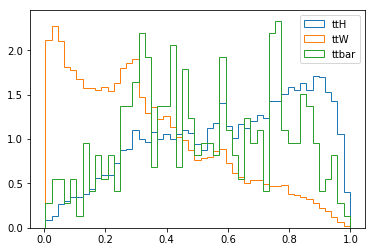

In [87]:
plt.figure()
lw = 2
#plt.plot(ttH_proc1,lw=lw, label='%s ROC (%0.3f)' % ("NN ", roc_auc_score(y_test, y_pred)))
nbins = 50
minval = np.amin(ttH_proc2)
maxval = max([np.amax(ttH_proc2), np.amax(ttW_proc2), np.amax(ttbar_proc2)]) #*1.4            
binning = np.linspace(minval,maxval,nbins)
plt.hist(ttH_proc2,binning,histtype=u'step',label='ttH',density=1) 
plt.hist(ttW_proc2,binning,histtype=u'step',label='ttW',density=1) 
plt.hist(ttbar_proc2,binning,histtype=u'step',label='ttbar',density=1) 
plt.legend()
#plt.savefig("Plots/ROC_NN_BDT_tth_ttw.png", transparent=True)
plt.show()

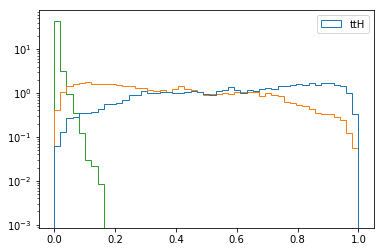

In [92]:
plt.figure()
lw = 2
binning = np.linspace(0,1,50)
plt.hist(ttH_proc1,binning,histtype=u'step',label='ttH',density=1,log=True) 
plt.hist(ttH_proc1,binning,histtype=u'step',label='ttH',density=1,log=True) 
plt.hist(ttH_proc1,binning,histtype=u'step',label='ttH',density=1,log=True) 

plt.legend()
#plt.savefig("Plots/ROC_NN_BDT_tth_ttw.png", transparent=True)
plt.show()

In [64]:
# 
#model = Sequential()
#model.add(Dense(len(variablelist), input_dim=len(variablelist), activation='relu'))
#model.add(Dropout(rate=0.1, noise_shape=None, seed=None))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(10, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

In [32]:
# Compile model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
nEpochs = 20
bSize = 100

In [34]:
# Fit the model
#nn_hist=model.fit(X_train, y_train, epochs=nEpochs, batch_size=bSize,validation_split=0.2) #, verbose=0

In [35]:
#evaluate the trained model
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 70.85%


In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                1860      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60)                240       
_________________________________________________________________
activation_1 (Activation)    (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                2928      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48)                192       
_________________________________________________________________
activation_2 (Activation)    (None, 48)                0         
__________

In [37]:

y_predicted = model.predict(X_test)
print (classification_report(y_test, y_predicted.round(), target_names=["signal", "background"]) )
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, y_predicted)) )



ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

In [38]:
fpr, tpr, _ = roc_curve(y_test, y_predicted)

ValueError: multilabel-indicator format is not supported

In [41]:
import xgboost
xgb_bdt = xgboost.XGBClassifier(tree_method="hist", thread_count=-1)
xgb_bdt.fit(X_train, y_train)
y_pred_xgb = xgb_bdt.predict(X_test)
xgb_bdt_ROC=roc_auc_score(y_test, xgb_bdt.predict_proba(X_test)[:, 1])
print("XGBoost ROC AUC = {:.3f}".format( xgb_bdt_ROC))


XGBoost ROC AUC = 0.762


In [48]:
fpr_bdt, tpr_bdt, _ = roc_curve(y_test, xgb_bdt.predict_proba(X_test)[:, 1])

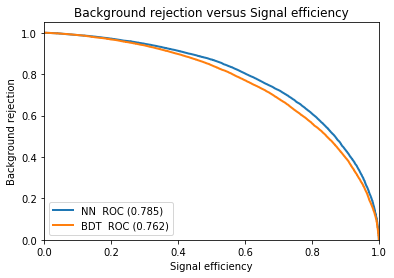

In [75]:
plt.figure()
lw = 2
plt.plot(tpr, 1-fpr, 
             lw=lw, label='%s ROC (%0.3f)' % ("NN ", roc_auc_score(y_test, y_predicted))) #color='darkorange',
plt.plot(tpr_bdt, 1-fpr_bdt, 
             lw=lw, label='%s ROC (%0.3f)' % ("BDT ", roc_auc_score(y_test, xgb_bdt.predict_proba(X_test)[:, 1]))) #color='darkorange',


#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#plt.plot(fpr, tpr, 
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
###########
#plt.plot(tpr, 1-fpr, lw=3)
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.title('Background rejection versus Signal efficiency')
plt.legend(loc="lower left")
#plt.yscale("log")
#plt.xlim(0.6,1)
#plt.ylim(0,1)
#plt.savefig("Plots/ROC_NN_BDT_tth_ttw.png", transparent=True)
plt.show()

In [39]:
nn_hist.history
epochs = np.arange(1,len(nn_hist.history['loss'])+1)

plt.plot(epochs,nn_hist.history['loss'],label='training')
plt.plot(epochs,nn_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('NN')

plt.show()

NameError: name 'nn_hist' is not defined

In [80]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)
nn_mChkPt = ModelCheckpoint('nn_weights.h5',monitor='val_loss', verbose=True,
                              save_best_only=True,
                              save_weights_only=True)


In [83]:
nnErSt_hist = model.fit(X_train, y_train, epochs=nEpochs, batch_size=bSize,validation_split=0.4,
                     callbacks=[earlyStop, nn_mChkPt])

Train on 62975 samples, validate on 41984 samples
Epoch 1/20
62975/62975 [==============================] - 1s 16us/step - loss: 0.5337 - acc: 0.7290 - val_loss: 0.5415 - val_acc: 0.7244

Epoch 00001: val_loss improved from 0.55462 to 0.54152, saving model to nn_weights.h5
Epoch 2/20
62975/62975 [==============================] - 1s 15us/step - loss: 0.5318 - acc: 0.7299 - val_loss: 0.5441 - val_acc: 0.7214

Epoch 00002: val_loss did not improve from 0.54152
Epoch 3/20
62975/62975 [==============================] - 1s 15us/step - loss: 0.5331 - acc: 0.7295 - val_loss: 0.5426 - val_acc: 0.7228

Epoch 00003: val_loss did not improve from 0.54152
Epoch 4/20
62975/62975 [==============================] - 1s 15us/step - loss: 0.5327 - acc: 0.7307 - val_loss: 0.5443 - val_acc: 0.7211

Epoch 00004: val_loss did not improve from 0.54152
Epoch 5/20
62975/62975 [==============================] - 1s 16us/step - loss: 0.5317 - acc: 0.7290 - val_loss: 0.5455 - val_acc: 0.7198

Epoch 00005: val_loss

In [40]:
epochs = np.arange(1,len(nnErSt_hist.history['loss'])+1)

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
#plt.set(fontsize=14)
ax[0].plot(epochs,nnErSt_hist.history['loss'],label='training')
ax[0].plot(epochs,nnErSt_hist.history['val_loss'],label='validation')
#plt.xlabel('epochs',fontsize=14)
ax[0].set(ylabel='cross-entropy loss')
ax[0].legend()
#ax[0].title('NN')
ax[1].plot(epochs,nnErSt_hist.history['acc'],label='training')
ax[1].plot(epochs,nnErSt_hist.history['val_acc'],label='training')
ax[1].legend()
ax[1].set(ylabel='Accuracy')
for axs in ax.flat:
    axs.set(xlabel='epochs')
plt.show()

NameError: name 'nnErSt_hist' is not defined

In [41]:
y_predicted = model.predict(X_test)
print (classification_report(y_test, y_predicted.round(), target_names=["signal", "background"]) )
print ("Area under ROC curve: %.4f"%(roc_auc_score(y_test, y_predicted)) )

ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter